# K-Nearest Neighbor Lab





In [31]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
from scipy.stats import mode
import os
import copy

In [32]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, columntype=[], weight_type='inverse_distance', nn=3, regress=False):
        self.columntype = columntype
        self.weight_type = weight_type
        self.nn = nn
        self.regress = regress

    def fit(self, data, labels):
        self.data = data
        self.labels = labels

    def braydens_dist(self, x, y):
        if x != y:
            return .5
        else:
            return 0
    
    def predict(self, x):
        predictions = []
        
        # Only do this pretty much for the credit data.
        if len(self.columntype) != 0:
            for i in range(x.shape[0]):
                distances = []
                for j in range(self.data.shape[0]):
                    values = []
                    for k in range(len(self.columntype)-1):
                        if self.columntype[k] == 1:
                            value = self.braydens_dist(x[i,k], self.data[j,k])
                        else:
                            value = np.square(x[i,k] - self.data[j,k])
                        values.append(value)
                    distances.append(np.sum(values))
                distances = np.array(distances)
                knn_indeces = np.argpartition(distances, self.nn)[:self.nn]
                knn_results = self.labels[knn_indeces]
                knn_distances = np.array(distances)[knn_indeces]
                knn_inverse_distances = []
                for dist in knn_distances:
                    if dist == 0:
                        knn_inverse_distances.append(0)
                    else:
                        knn_inverse_distances.append(1/(dist**2))
                temp = np.column_stack((knn_results, knn_inverse_distances))
                d = {}
                for i in range(temp.shape[0]):
                    if temp[i][0] in d.keys():
                        d[temp[i][0]] += float(temp[i][1])
                    else:
                        d[temp[i][0]] = float(temp[i][1])
                if self.weight_type == 'no_weight':
                    predictions.append(mode(knn_results)[0][0])
                elif self.weight_type == 'inverse_distance':
                    predictions.append(max(d, key=d.get))
                else:
                    print('You need to specify the weight')
            return predictions

        else:
            for i in range(x.shape[0]):
                distances = np.linalg.norm(x[i] - self.data, axis=1)
                knn_indeces = np.argpartition(distances, self.nn)[:self.nn]
                knn_results = self.labels[knn_indeces]
                knn_distances = np.array(distances)[knn_indeces]
                knn_inverse_distances = []
                for dist in knn_distances:
                    if dist == 0:
                        knn_inverse_distances.append(0)
                    else:
                        knn_inverse_distances.append(1/(dist**2))
                temp = np.column_stack((knn_results, knn_inverse_distances))
                d = {}
                for i in range(temp.shape[0]):
                    if temp[i][0] in d.keys():
                        d[temp[i][0]] += float(temp[i][1])
                    else:
                        d[temp[i][0]] = float(temp[i][1])
                if self.weight_type == 'no_weight':
                    predictions.append(mode(knn_results)[0][0])
                elif self.weight_type == 'inverse_distance':
                    predictions.append(max(d, key=d.get))
                else:
                    print('You need to specify the weight')
            return predictions

    def predict_regress(self, x):
        predictions = []
        for i in range(x.shape[0]):
            distances = np.linalg.norm(x[i] - self.data, axis=1)
            knn_indeces = np.argpartition(distances, self.nn)[:self.nn]
            knn_results = self.labels[knn_indeces]
            knn_distances = np.array(distances)[knn_indeces]
            knn_inverse_distances = []
            for dist in knn_distances:
                if dist == 0:
                    knn_inverse_distances.append(0)
                else:
                    knn_inverse_distances.append(1/(dist**2))
            temp = np.column_stack((knn_results, knn_inverse_distances))
            if self.weight_type == 'inverse_distance':
                predictions.append(np.prod(temp, axis=1).sum() / np.sum(temp, axis=0)[1])
            else:
                predictions.append(np.mean(temp, axis=0)[0])
        return predictions

    def score(self, x, y):
        if self.regress == False:
            predictions = self.predict(x)
            return (predictions == y).mean()
        else:
            predictions = self.predict_regress(x)
            return np.mean(np.square(predictions - y))

In [33]:
def normalize(train, test):
    w = copy.deepcopy(train)
    y = copy.deepcopy(test)
    t = np.vstack((w,y))
    for i in range(t.shape[1]):
        t_max, t_min = max(t[:,i]), min(t[:,i])
        for j in range(w.shape[0]):
            w[j,i] = (w[j][i] - t_min) / (t_max - t_min)
        for k in range(y.shape[0]):
            y[k,i] = (y[k][i] - t_min) / (t_max - t_min)
    return w, y

In [34]:
# Glass Data
glass_train = pd.DataFrame(arff.loadarff('datasets/glass_train.arff')[0])
glass_test = pd.DataFrame(arff.loadarff('datasets/glass_test.arff')[0])

glass_train['Type'] = glass_train['Type'].str.decode('utf8')
glass_test['Type'] = glass_test['Type'].str.decode('utf8')

glass_train_x = np.array(glass_train.iloc[:, 0:-1])
glass_train_y = np.array(glass_train.iloc[:, -1])

glass_test_x = np.array(glass_test.iloc[:, 0:-1])
glass_test_y = np.array(glass_test.iloc[:, -1])

In [35]:
# Glass Results
glass_knn_no_weight = KNNClassifier(columntype=[], weight_type='no_weight', nn=3)
glass_knn_weight = KNNClassifier(columntype=[], weight_type='inverse_distance', nn=3)

glass_knn_no_weight.fit(data=glass_train_x, labels=glass_train_y)
glass_knn_weight.fit(data=glass_train_x, labels=glass_train_y)

print('Glass')
print('Score with No Weight:', glass_knn_no_weight.score(x=glass_test_x, y=glass_test_y))
print('Score with Inverse Weighting:', glass_knn_weight.score(x=glass_test_x, y=glass_test_y))

Glass
Score with No Weight: 0.6829268292682927
Score with Inverse Weighting: 0.7439024390243902


### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff)

In [36]:
# Diabetes Data
diabetes_train = pd.DataFrame(arff.loadarff('datasets/diabetes_train.arff')[0])
diabetes_test = pd.DataFrame(arff.loadarff('datasets/diabetes_test.arff')[0])

diabetes_train['class'] = diabetes_train['class'].str.decode('utf8')
diabetes_test['class'] = diabetes_test['class'].str.decode('utf8')

diabetes_train_x = np.array(diabetes_train.iloc[:, 0:-1])
diabetes_train_y = np.array(diabetes_train.iloc[:, -1])

diabetes_test_x = np.array(diabetes_test.iloc[:, 0:-1])
diabetes_test_y = np.array(diabetes_test.iloc[:, -1])

In [37]:
# Diabetes Results
diabetes_knn_no_weight = KNNClassifier(columntype=[], weight_type='no_weight', nn=3)
diabetes_knn_weight = KNNClassifier(columntype=[], weight_type='inverse_distance', nn=3)

diabetes_knn_no_weight.fit(data=diabetes_train_x, labels=diabetes_train_y)
diabetes_knn_weight.fit(data=diabetes_train_x, labels=diabetes_train_y)

print('Diabetes')
print('Score with No Weight:', diabetes_knn_no_weight.score(x=diabetes_test_x, y=diabetes_test_y))
print('Score with Inverse Weighting:', diabetes_knn_weight.score(x=diabetes_test_x, y=diabetes_test_y))

Diabetes
Score with No Weight: 0.8411458333333334
Score with Inverse Weighting: 0.890625


In [38]:
# Magic Telescope Data
mt_train = pd.DataFrame(arff.loadarff('datasets/magic_telescope_train.arff')[0])
mt_test = pd.DataFrame(arff.loadarff('datasets/magic_telescope_test.arff')[0])

mt_train['class'] = mt_train['class'].str.decode('utf8')
mt_test['class'] = mt_test['class'].str.decode('utf8')

mt_train_x = np.array(mt_train.iloc[:, 0:-1])
mt_train_y = np.array(mt_train.iloc[:, -1])

mt_test_x = np.array(mt_test.iloc[:, 0:-1])
mt_test_y = np.array(mt_test.iloc[:, -1])

mt_train_x_norm = normalize(mt_train_x, mt_test_x)[0]
mt_test_x_norm = normalize(mt_train_x, mt_test_x)[1]

### 2.1

In [39]:
# Magic Telescope Results: No Normalization
mt_knn_no_weight = KNNClassifier(columntype=[], weight_type='no_weight', nn=3)
mt_knn_weight = KNNClassifier(columntype=[], weight_type='inverse_distance', nn=3)

mt_knn_no_weight.fit(data=mt_train_x, labels=mt_train_y)
mt_knn_weight.fit(data=mt_train_x, labels=mt_train_y)

print('No Normalization')
print('Score with No Weight:', mt_knn_no_weight.score(x=mt_test_x, y=mt_test_y))
print('Score with Inverse Weighting:', mt_knn_weight.score(x=mt_test_x, y=mt_test_y))

No Normalization
Score with No Weight: 0.8082808280828083
Score with Inverse Weighting: 0.8046804680468047


### 2.2

In [40]:
# # Magic Telescope Results: With Normalization
mt_knn_no_weight = KNNClassifier(columntype=[], weight_type='no_weight', nn=3)
mt_knn_weight = KNNClassifier(columntype=[], weight_type='inverse_distance', nn=3)

mt_knn_no_weight.fit(data=mt_train_x_norm, labels=mt_train_y)
mt_knn_weight.fit(data=mt_train_x_norm, labels=mt_train_y)

print('With Normalization')
print('Score with No Weight:', mt_knn_no_weight.score(x=mt_test_x_norm, y=mt_test_y))
print('Score with Inverse Weighting:', mt_knn_weight.score(x=mt_test_x_norm, y=mt_test_y),'\n')

With Normalization
Score with No Weight: 0.8304830483048304
Score with Inverse Weighting: 0.8295829582958296 



This might seem a little weird what I was doing, but when I normalized the train_x data just by itself, it used the max_x value within its data and the min_x value within its data to compute the normalization for each data point. This returned a normalized version of the train_x data to me. This is what I mean by "Normalize Separately."

But when I pass in both the train_x and the test_x data at the same time, I can use the min_x from the combined dataset to normalize over both the train_x and the test_x. This is what I mean by "Normalize Together."

But at the end of it all, normalization does increase score -- if marginally.

In [41]:
# Train/Predict with normalization using k=1,3,...,15
mt_scores = []
for k in range(1,16,2):
    knn = KNNClassifier(weight_type='inverse_distance', nn=k)
    knn.fit(mt_train_x_norm, mt_train_y)
    mt_scores.append(knn.score(mt_test_x_norm, mt_test_y))

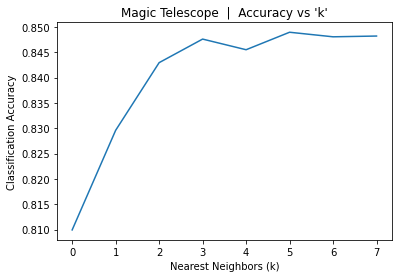

In [42]:
# Graph classification accuracy over k
plt.plot(mt_scores)
plt.xlabel('Nearest Neighbors (k)')
plt.ylabel('Classification Accuracy')
plt.title('Magic Telescope  |  Accuracy vs \'k\'')
plt.show()

In [43]:
# Housing Data
house_train = pd.DataFrame(arff.loadarff('datasets/housing_train.arff')[0])
house_test = pd.DataFrame(arff.loadarff('datasets/housing_test.arff')[0])

house_train['CHAS'] = house_train['CHAS'].str.decode('utf8').astype(dtype=int)
house_test['CHAS'] = house_test['CHAS'].str.decode('utf8').astype(dtype=int)

house_train_x = np.array(house_train.iloc[:, 0:-1])
house_train_y = np.array(house_train.iloc[:, -1])

house_test_x = np.array(house_test.iloc[:, 0:-1])
house_test_y = np.array(house_test.iloc[:, -1])

house_train_x_norm = normalize(house_train_x, house_test_x)[0]
house_test_x_norm = normalize(house_train_x, house_test_x)[1]

In [44]:
house_knn = KNNClassifier(weight_type='no_weight', nn=3, regress=True)
house_knn.fit(house_train_x_norm, house_train_y)
print('Housing MSE:',house_knn.score(house_test_x_norm, house_test_y))

Housing MSE: 16.598692810457518


In [45]:
house_mses_no_weight = []
for k in range(1,16,2):
    knn = KNNClassifier(weight_type='no_weight', nn=k, regress=True)
    knn.fit(house_train_x_norm, house_train_y)
    house_mses_no_weight.append(knn.score(house_test_x_norm, house_test_y))

In [46]:
house_mses_weight = []
for k in range(1,16,2):
    knn = KNNClassifier(weight_type='inverse_distance', nn=k, regress=True)
    knn.fit(house_train_x_norm, house_train_y)
    house_mses_weight.append(knn.score(house_test_x_norm, house_test_y))

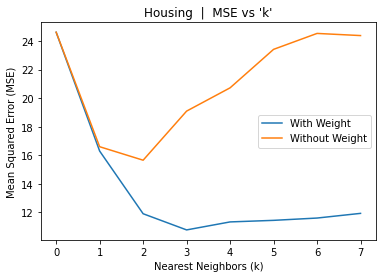

In [47]:
# Graph MSE over k
plt.plot(house_mses_weight)
plt.plot(house_mses_no_weight)
plt.xlabel('Nearest Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Housing  |  MSE vs \'k\'')
plt.legend(['With Weight','Without Weight'])
plt.show()

## Magic Telescope Dataset

In [48]:
# Train/Predict magic telescope using distance-weighted voting
mt_knn = KNNClassifier(weight_type='inverse_distance', nn=3)
mt_knn.fit(mt_train_x_norm, mt_train_y)
mt_knn_weight.score(mt_test_x_norm, mt_test_y)

0.8295829582958296

## Housing Dataset

In [49]:
# Train/Predict housing using distance-weighted voting
house_knn = KNNClassifier(weight_type='inverse_distance', nn=3, regress=True)
house_knn.fit(house_train_x_norm, house_train_y)
house_knn.score(house_test_x_norm, house_test_y)

16.294702431167742

Interestingly, the inverse distance didn't improve the accuracy very crazily for the magic telescope dataset. But for the houses, you can see in the above graph that I added another line that shows how when the number of k nearest neighbors increased, the MSE continued to decrease slowly when there was inverse weight distancing, but took off when there was no weighting.

## Credit Approval


In [50]:
def get_column_types(df):
    c_types = df.dtypes.astype(str)
    c_types = c_types.map({'float64':0, 'object':1})

In [51]:
# Credit Data
credit = pd.DataFrame(arff.loadarff('datasets/credit_approval.arff')[0])

credit['A1'] = credit['A1'].str.decode('utf8')
credit['A4'] = credit['A4'].str.decode('utf8')
credit['A5'] = credit['A5'].str.decode('utf8')
credit['A6'] = credit['A6'].str.decode('utf8')
credit['A7'] = credit['A7'].str.decode('utf8')
credit['A9'] = credit['A9'].str.decode('utf8')
credit['A10'] = credit['A10'].str.decode('utf8')
credit['A12'] = credit['A12'].str.decode('utf8')
credit['A13'] = credit['A13'].str.decode('utf8')
credit['class'] = credit['class'].str.decode('utf8')

# 0 = 'real', 1 = 'nominal'
col_types = np.array(credit.dtypes.astype(str).map({'float64':0, 'object':1}))

# Normalize Continuous Features
for i in range(len(col_types)):
    if col_types[i] == 0:
        col_min = credit.iloc[:,i].min()
        col_max = credit.iloc[:,i].max()
        credit.iloc[:,i] = (credit.iloc[:,i] - col_min) / (col_max - col_min)

credit_x = np.array(credit.iloc[:, 0:-1])
credit_y = np.array(credit.iloc[:, -1])

credit_train_x, credit_test_x, credit_train_y, credit_test_y = train_test_split(credit_x, credit_y, test_size=.3)

In [52]:
credit_knn = KNNClassifier(columntype=col_types, weight_type='no_weight')
credit_knn.fit(credit_train_x, credit_train_y)
credit_knn.score(credit_test_x, credit_test_y)

0.821256038647343

So I am using a very clever way of doing distance. I call it 'Brayden's Distance.' Simply put, I go through value by value, and if the data type is nominal, then I simply see if the value is equal to itself, if it is, then there's no differnece, so I assign the difference for that particular instance to be '0.' But if they are different, then I just say that the difference for that particular dual off is .5 which is reasonable considering that all the real data has been normalized before passing it in.

Then you simply sum the actual differences squared and the .5s or 0s from the nominal and get a distance for that particular instance. All of this is in lieue of the Euclidean distance which my algorithm simply calculcates when I don't pass in different column types.

In [29]:
# Train/Predict magic telescope using scikit's KNN
magic_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto',leaf_size=30, p=2,
                                metric='minkowski', metric_params=None, n_jobs=None)
magic_knn.fit(mt_train_x_norm, mt_train_y)
print('Magic Telescope Score:', magic_knn.score(mt_test_x_norm, mt_test_y))

Magic Telescope Score: 0.8432343234323433


In [57]:
# Train/Predict magic telescope using scikit's KNN
magic_knn = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='auto',leaf_size=30, p=2,
                                metric='minkowski', metric_params=None, n_jobs=None)
magic_knn.fit(mt_train_x_norm, mt_train_y)
print('Magic Telescope Score:', magic_knn.score(mt_test_x_norm, mt_test_y))

Magic Telescope Score: 0.8492349234923492


In [55]:
# Train/Predict magic telescope using scikit's KNN
magic_knn = KNeighborsClassifier(n_neighbors=2, weights='uniform', algorithm='auto',leaf_size=30, p=2,
                                metric='minkowski', metric_params=None, n_jobs=None)
magic_knn.fit(mt_train_x_norm, mt_train_y)
print('Magic Telescope Score:', magic_knn.score(mt_test_x_norm, mt_test_y))

Magic Telescope Score: 0.8135313531353136


In [30]:
# Train/Predict housing using scikit's KNN
house_knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto',leaf_size=30, p=2,
                                metric='minkowski', metric_params=None, n_jobs=None)
house_knn.fit(house_train_x_norm, house_train_y)
print('Housing Score:', house_knn.score(house_test_x_norm, house_test_y))

Housing Score: 0.7957406361552128


In [58]:
# Train/Predict housing using scikit's KNN
house_knn = KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto',leaf_size=30, p=2,
                                metric='minkowski', metric_params=None, n_jobs=None)
house_knn.fit(house_train_x_norm, house_train_y)
print('Housing Score:', house_knn.score(house_test_x_norm, house_test_y))

Housing Score: 0.7996056686075668


In [59]:
# Train/Predict housing using scikit's KNN
house_knn = KNeighborsRegressor(n_neighbors=10, weights='distance', algorithm='auto',leaf_size=30, p=2,
                                metric='minkowski', metric_params=None, n_jobs=None)
house_knn.fit(house_train_x_norm, house_train_y)
print('Housing Score:', house_knn.score(house_test_x_norm, house_test_y))

Housing Score: 0.8076712021981529


### Report your comparison
For the Magic Telescope dataset (the knn Classifier), the results between the sklearn version and my version is strikingly close. The sklearn is getting an accuracy of 84.3% and my model got up to 83.05% when there were no weights used and the inputs were normalized. Even with some tweaking and fine-tuning, the results are strikingly close.

For the housing dataset, I didn't calculate an accuracy score for the regression output; rather, I calculated the MSE so it makes it a little difficult to compare with the score given by the sklearn model, but I learned from Brayden Smith that sklearn returns the coefficient of determination rather than the MSE.